This is my first attempt at solving Kaggle's Titanic: Machine Learning from Disaster competition.

Objectives:
- Based on the available data, create a model that can accurately detemine which passanger will survive

# Notebook setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from collections import Counter
import personal

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('darkgrid')

 # Disable trunkating the middle of long dataframes. I want to see all the columns.
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Explore data

In [5]:
trainDF = pd.read_csv("input/train.csv")
testDF = pd.read_csv("input/test.csv")

In [6]:
combineDF = pd.concat([trainDF, testDF], axis=0).reset_index(drop=True)
combineDF = combineDF.fillna(np.nan)

## Missing values

In [7]:
combineDF.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [8]:
combineDF.isnull().sum() / combineDF.shape[0]

Age            0.200917
Cabin          0.774637
Embarked       0.001528
Fare           0.000764
Name           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Survived       0.319328
Ticket         0.000000
dtype: float64

- Cabin has a very high number of missing values. Consider leaving it out for the initial model and revisit later to try to improve the model further.
- Age also has quite a lot of missing values. Intuition would suggest that it should have a very important role in survival (remember "Women and chilren first!" from the movie), so we should take care of the missing values.
- Embarked and Fare have a much lower % of missing values, there's only 2 and 1 observation that are missing these. As a first step, we should use some basic way of imputing these.

## Numeric variables

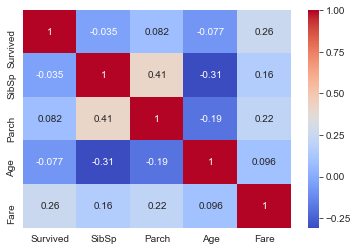

In [9]:
sns.heatmap(trainDF[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, cmap='coolwarm');

Fare shows the highest corelation. Most likely more expensive tickets meant more priviledged passangers. Keep this in mind.

### Siblings and Spouses

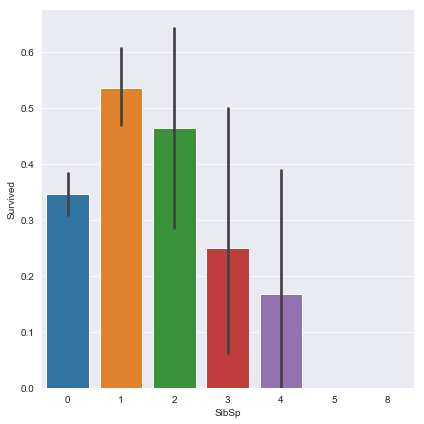

In [10]:
sns.factorplot(x='SibSp', y='Survived', data=trainDF, kind='bar', size=6);

### Parents and Children

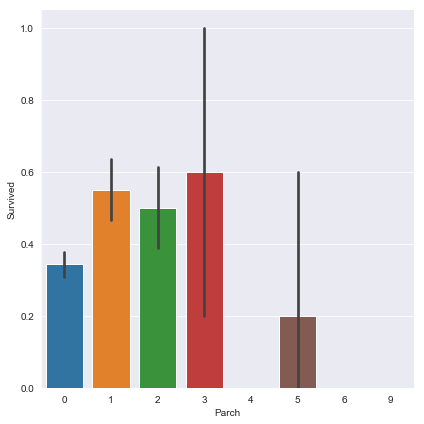

In [11]:
sns.factorplot(x='Parch', y='Survived', data=combineDF, kind='bar', size=6);

### Age

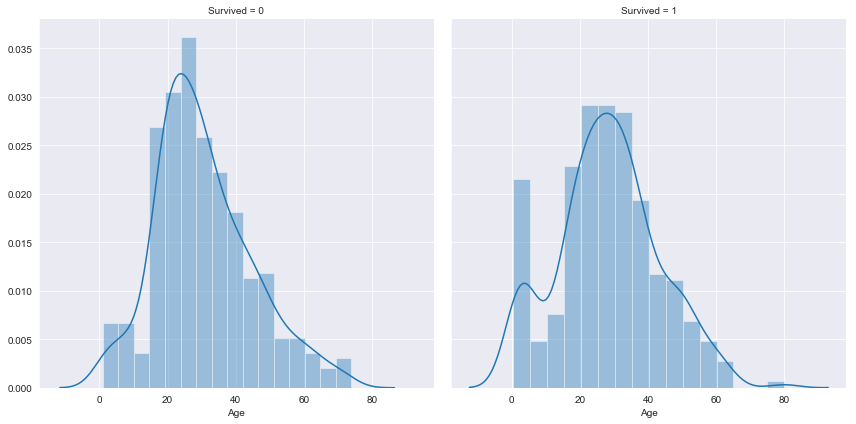

In [12]:
g = sns.FacetGrid(trainDF, col='Survived', size=6);
g = g.map(sns.distplot, "Age");

Looking at Age, there is a significant spike for very younger passangers. Babies and children seem more likely to have survived.

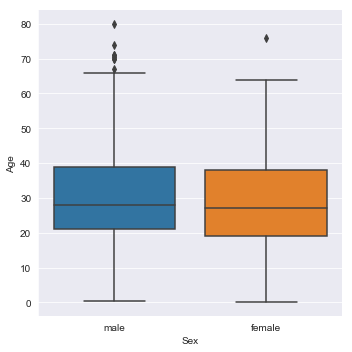

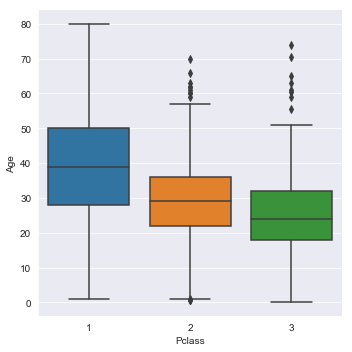

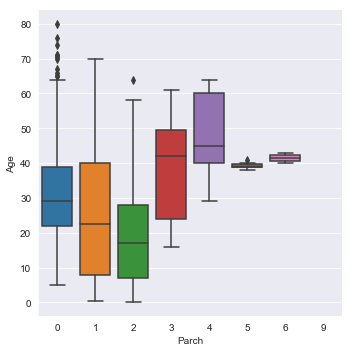

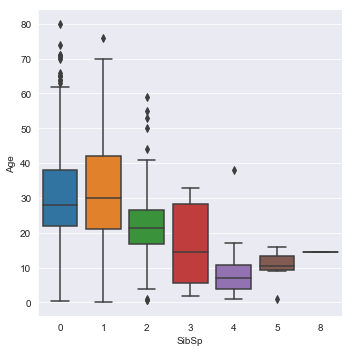

In [13]:
g = sns.factorplot(y='Age', x='Sex', data=combineDF, kind="box")
g = sns.factorplot(y='Age', x='Pclass', data=combineDF, kind="box")
g = sns.factorplot(y='Age', x='Parch', data=combineDF, kind="box")
g = sns.factorplot(y='Age', x='SibSp', data=combineDF, kind="box")

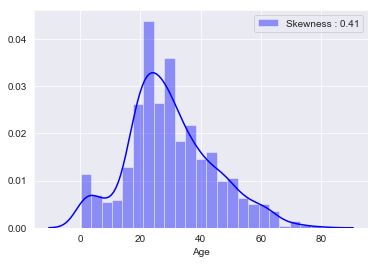

In [14]:
ages = combineDF[combineDF.Age.notnull()].Age
g = sns.distplot(ages, color='b', label="Skewness : %.2f"%(ages.skew()))
g = g.legend(loc='best');

Age is less skewed. For the initial model, we won't modify it.

### Fare

In [15]:
duplicates = pd.concat(g for _, g in combineDF.groupby('Ticket') if len(g) > 1)
duplicates.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
257,30.0,B77,S,86.50,"Cherry, Miss. Gladys",0,258,1,female,0,1.0,110152
504,16.0,B79,S,86.50,"Maioni, Miss. Roberta",0,505,1,female,0,1.0,110152
759,33.0,B77,S,86.50,"Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)",0,760,1,female,0,1.0,110152
262,52.0,E67,S,79.65,"Taussig, Mr. Emil",1,263,1,male,1,0.0,110413
558,39.0,E67,S,79.65,"Taussig, Mrs. Emil (Tillie Mandelbaum)",1,559,1,female,1,1.0,110413


Looking at Tickets, some passanger have the same Ticket and same Fare, meaning they bought a group ticket. The fare value is incorrect in this case, as it should be split evenly across each person. Keep this in mind.

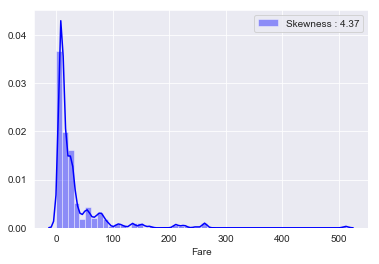

In [16]:
fares = combineDF.Fare[combineDF.Fare.isnull() == False]
g = sns.distplot(fares, color='b', label="Skewness : %.2f"%(fares.skew()))
g = g.legend(loc='best')

Fare is significantly skewed. Looking at the distplot, a log transformation would be helpful.

## Categorical variables

### Passanger class

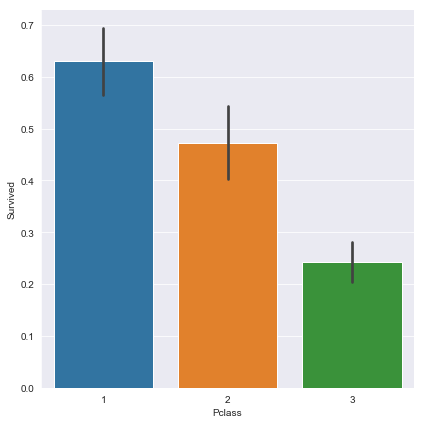

In [17]:
sns.factorplot(x='Pclass', y='Survived', data=combineDF, kind="bar", size=6);

As expected, there's a significant dropoff in survival rates in lower passanger classes.

### Gender

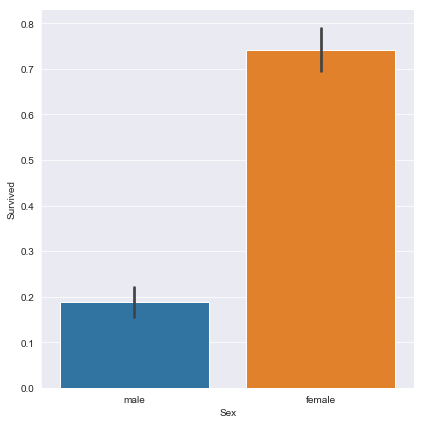

In [18]:
sns.factorplot(x='Sex', y='Survived', data=combineDF, kind="bar", size=6);

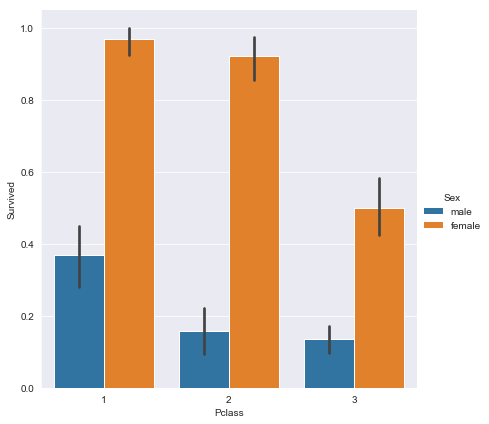

In [19]:
sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=combineDF, kind="bar", size=6);

Not surprisingly, women had a much higher survival rate.

### Cabin

In [20]:
combineDF.Cabin = combineDF.Cabin.fillna('X')
combineDF.Cabin = list(map(lambda x: x[0], combineDF.Cabin))

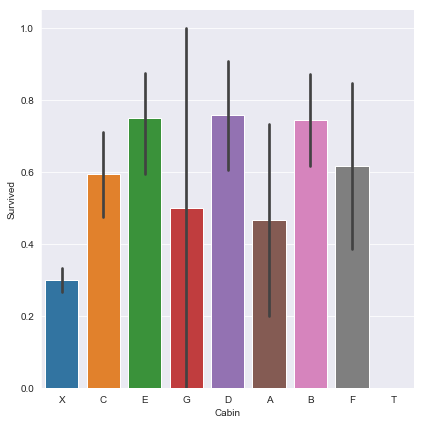

In [21]:
sns.factorplot(x='Cabin', y='Survived', data=combineDF, kind="bar", size=6);

Weirdly enough, those that did not have a cabin assigned had a much lower change of survival. Perhaps Cabin is correlated with Pclass?

# Cleanup

As discussed earlier, some passangers have a group ticket, so Fare is not representative. The fare should be split evenly across ticket holders.

In [22]:
def handle_same_tickets(df):
    duplicates = pd.concat(g for _, g in df.groupby('Ticket') if len(g) > 1)
    duplicates.drop_duplicates(subset=['Ticket'], inplace=True)
    duplicate_tickets = duplicates['Ticket']
    
    ticket_price_map = {}
    for ticket in duplicate_tickets:
        same = df[df.Ticket == ticket]
        distinct_fares = same.drop_duplicates(subset=['Fare'])
        if len(distinct_fares) > 1:
            # For some reason there's one group, with Ticket = 7534 who have distinct Fare values, skip that
            continue
        group_size = len(same)
        ticket_price_map[ticket] = same.iloc[1]['Fare'] / group_size
        
        
    return df.apply(lambda x: ticket_price_map[x['Ticket']] if x['Ticket'] in ticket_price_map.keys() else x['Fare'], axis=1)

In [23]:
combineDF.Fare = handle_same_tickets(combineDF)

## Outliers

For the first model, we will drop outliers based on the Tukey method (1.5 * IQR)

In [24]:
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1

        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
outliers_to_drop = detect_outliers(trainDF, 2, ['Age', 'SibSp', 'Parch', 'Fare'])
trainDF.loc[outliers_to_drop]

trainDF = trainDF.drop(outliers_to_drop, axis=0).reset_index(drop=True)

## Missing values

### Fare

In [25]:
combineDF[combineDF.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,X,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


For now, just use the median value based on Pclass and Embarked.

In [26]:
people = combineDF[(combineDF.Embarked == 'S') & (combineDF.Pclass == 3)]
combineDF.loc[combineDF.PassengerId == 1044, 'Fare'] = people.Fare.median()

### Embarked

In [27]:
combineDF[combineDF['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B,NaN,40.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B,NaN,40.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [28]:
embarkedS = combineDF[(combineDF.Embarked == 'S') & (combineDF.Pclass == 1)]
embarkedC = combineDF[(combineDF.Embarked == 'C') & (combineDF.Pclass == 1)]
embarkedQ = combineDF[(combineDF.Embarked == 'Q') & (combineDF.Pclass == 1)]

print('S: ', embarkedS.Fare.median())
print('C: ', embarkedC.Fare.median())
print('Q: ', embarkedQ.Fare.median())

S:  26.55
C:  34.65
Q:  30.0


Embarked C has the highest and closest median Fare price. Use that for missing values.

In [29]:
combineDF.loc[combineDF.PassengerId == 62, 'Embarked'] = 'C'
combineDF.loc[combineDF.PassengerId == 830, 'Embarked'] = 'C'

### Sex

In [30]:
combineDF.Sex = combineDF.Sex.map({'male': 0, 'female': 1})
combineDF.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,X,S,7.25000,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171
1,38.0,C,C,35.64165,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,1,1,1.0,PC 17599
2,26.0,X,S,7.92500,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282
3,35.0,C,S,26.55000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803
4,35.0,X,S,8.05000,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450


### Fare

Apply a log transformation to reduce skewness.

In [31]:
combineDF.Fare = combineDF.Fare.map(lambda i: np.log(i) if i > 0 else 0)

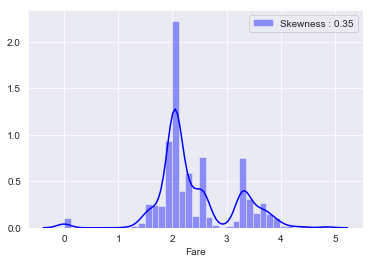

In [32]:
fares = combineDF.Fare
g = sns.distplot(fares, color='b', label="Skewness : %.2f"%(fares.skew()))
g = g.legend(loc='best')

### Age

In one of the R kernels, I saw a model that was preforming extremely well used MICE imputation for the age variable instead of trying to deal with it by hand. I will try to replicate the same thing in Python.

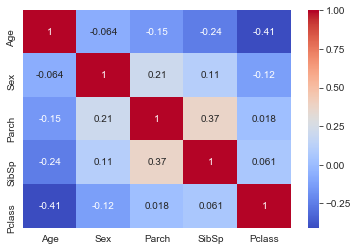

In [33]:
sns.heatmap(combineDF[['Age', 'Sex', 'Parch', 'SibSp', 'Pclass']].corr(), annot=True, cmap='coolwarm');

In [34]:
features = combineDF.copy()
features.drop(labels=['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
features = pd.get_dummies(features, columns=['Embarked'])
features.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1.981001,0,1,3,0,1,0.0,0,0,1
1,38.0,3.573515,0,2,1,1,1,1.0,1,0,0
2,26.0,2.070022,0,3,3,1,0,1.0,0,0,1
3,35.0,3.279030,0,4,1,1,1,1.0,0,0,1
4,35.0,2.085672,0,5,3,0,0,0.0,0,0,1


In [35]:
from fancyimpute import IterativeImputer 

filled = IterativeImputer().fit_transform(np.array(features))

Using TensorFlow backend.


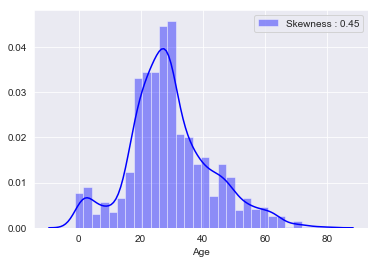

In [36]:
cols = list(features)
results = pd.DataFrame(filled, columns=cols)
ages = results.Age
g = sns.distplot(ages, color='b', label="Skewness : %.2f"%(ages.skew()))
g = g.legend(loc='best')

combineDF.Age = ages

# Feature Engineering

## Title

In [37]:
r = re.compile('(\w*)(\.)')
titles = list(map(lambda x: r.search(x).group(1), combineDF['Name']))

c = Counter(titles)
c.items()

dict_items([('Mr', 757), ('Mrs', 197), ('Miss', 260), ('Master', 61), ('Don', 1), ('Rev', 8), ('Dr', 8), ('Mme', 1), ('Ms', 2), ('Major', 2), ('Lady', 1), ('Sir', 1), ('Mlle', 2), ('Col', 4), ('Capt', 1), ('Countess', 1), ('Jonkheer', 1), ('Dona', 1)])

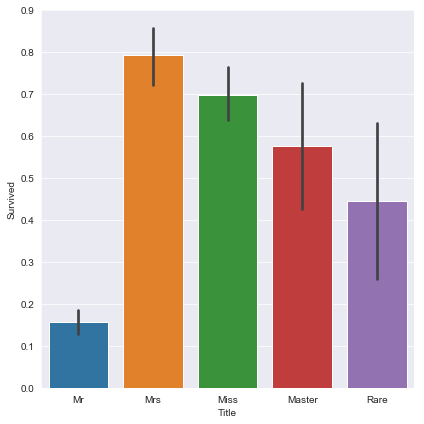

In [38]:
titles = list(map(lambda x: x if c[x] > 10 else 'Rare', titles))
combineDF['Title'] = titles
sns.factorplot(x='Title', y='Survived', data=combineDF, kind="bar", size=6);

## Family size

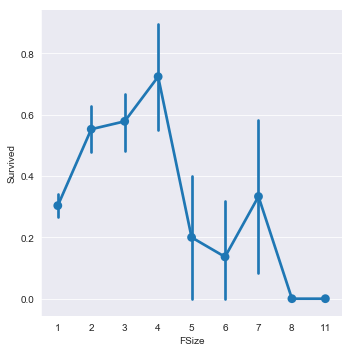

In [39]:
combineDF['FSize'] = combineDF.SibSp + combineDF.Parch + 1
sns.factorplot(x='FSize', y='Survived', data=combineDF);

In [40]:
def group_fsize(x): 
    if x == 1:
        return "Alone"
    elif x <= 4:
        return "Small"
    else:
        return "Large"

combineDF['FGroup'] = list(map(group_fsize, combineDF.FSize))

## Ticket

In [41]:
Ticket = []
for i in list(combineDF.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".", "").replace("/", "").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")

combineDF['Ticket'] = Ticket
combineDF['Ticket'].head()

0    A5    
1    PC    
2    STONO2
3    X     
4    X     
Name: Ticket, dtype: object

## Age group

In [42]:
def group_age(x): 
    if x <= 8:
        return "Child"
    elif x <= 18:
        return "Teen"
    elif x <= 40:
        return "Mid"
    elif x <= 60:
        return "Late"
    else:
        return "Elderly"

combineDF['AgeGroup'] = list(map(group_age, combineDF.Age))

# Preprocessing

Final cleanup before passing data to model:
- Removing variables
- Scaling
- Dummy variables

In [43]:
from sklearn import preprocessing

In [44]:
combineDF.drop(labels=['Name'], axis=1, inplace=True)

In [45]:
combineDF = pd.get_dummies(combineDF, columns=['Cabin'])
combineDF = pd.get_dummies(combineDF, columns=['Embarked'])
combineDF = pd.get_dummies(combineDF, columns=['Title'])
combineDF = pd.get_dummies(combineDF, columns=['FGroup'])
combineDF = pd.get_dummies(combineDF, columns=['Pclass'])
combineDF = pd.get_dummies(combineDF, columns=['Ticket'])
combineDF = pd.get_dummies(combineDF, columns=['AgeGroup'])

In [46]:
trainDF = combineDF[combineDF.PassengerId <= 891].copy()
testDF = combineDF[combineDF.PassengerId > 891].copy()
testDF.reset_index(inplace=True, drop=True)
testDF.drop(labels=['Survived'], axis=1, inplace=True)

labels = ['Age', 'Fare', 'Parch', 'SibSp', 'FSize']
scaler = preprocessing.StandardScaler().fit(trainDF[labels])
trainDF[labels] = scaler.transform(trainDF[labels])
testDF[labels] = scaler.transform(testDF[labels])

In [47]:
testDF.head()

,Age,Fare,Parch,PassengerId,Sex,SibSp,FSize,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FGroup_Alone,FGroup_Large,FGroup_Small,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_X,AgeGroup_Child,AgeGroup_Elderly,AgeGroup_Late,AgeGroup_Mid,AgeGroup_Teen
0,0.380770,-0.464276,-0.473674,892,0,-0.474545,-0.560975,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,1.300472,-0.618641,-0.473674,893,1,0.432793,0.059160,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,2.404114,-0.170609,-0.473674,894,0,-0.474545,-0.560975,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,-0.171051,-0.324813,-0.473674,895,0,-0.474545,-0.560975,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,-0.538932,-0.798549,0.767630,896,1,0.432793,0.679295,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


# Modelling

In [48]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,\
	ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [49]:
trainDF.Survived = trainDF.Survived.astype(int)
Y_train = trainDF.Survived
X_train = trainDF.drop(labels=['Survived', 'PassengerId'], axis=1)

## Explore potential models

In [50]:
kfold = StratifiedKFold(n_splits=10)

random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy',  cv=kfold))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans':cv_means,'CrossValerrors':
	cv_std,'Algorithm':['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees',
                        'GradientBoosting', 'MultipleLayerPerceptron', 'KNeighboors', 'LogisticRegression']})

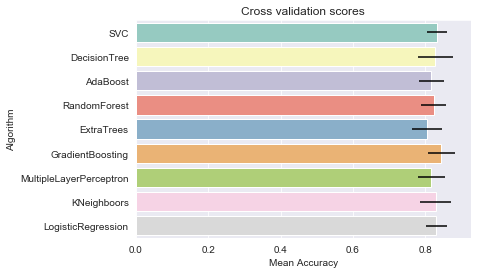

In [51]:
g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

Based on the Cross Validation score, I chose the following models for ensembling:
- Gradient boosting
- KNN
- Logistic regression

## Tuning individual models

In [52]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose = 1)
gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 308 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   25.8s finished


0.8574635241301908

In [54]:
### KNN

KNN = KNeighborsClassifier()
param_grid = {
    'n_neighbors' : [3, 5, 7, 9, 11, 15, 18, 25],
    'weights' : ['uniform', 'distance'],
    'leaf_size' : [20, 30, 40, 50],
    'p': [1, 2]
}

gsKNN = GridSearchCV(KNN, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsKNN.fit(X_train, Y_train)
KNN_best = gsKNN.best_estimator_

gsKNN.best_score_

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 348 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 1280 out of 1280 | elapsed:   18.4s finished


0.8338945005611672

In [55]:
### Logistic Regression

LR = LogisticRegression()
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

gsLR = GridSearchCV(LR, param_grid=param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsLR.fit(X_train, Y_train)
LR_best = gsLR.best_estimator_

gsLR.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.2s finished


0.8305274971941639

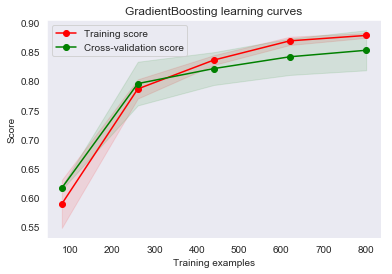

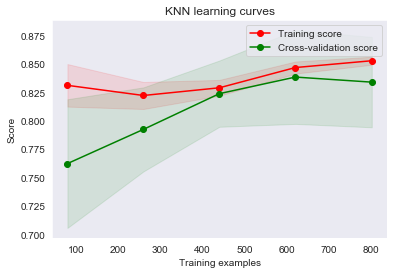

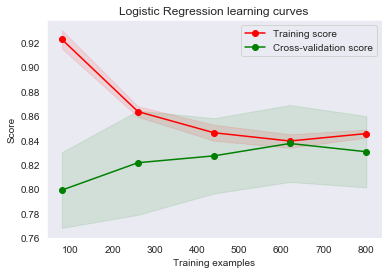

In [58]:
g = personal.plot_learning_curve(GBC_best, "GradientBoosting learning curves", X_train, Y_train, cv=kfold)
g = personal.plot_learning_curve(KNN_best, "KNN learning curves", X_train, Y_train, cv=kfold);
g = personal.plot_learning_curve(LR_best, "Logistic Regression learning curves", X_train, Y_train, cv=kfold);

## Ensembling

In [59]:
testID = testDF.PassengerId
X_test = testDF.drop(labels=['PassengerId'], axis=1)

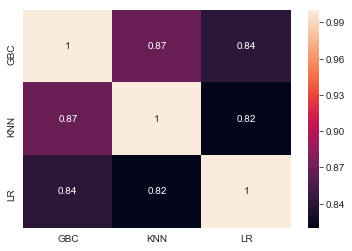

In [60]:
test_Survived_GBC = pd.Series(GBC_best.predict(X_test), name="GBC")
test_Survived_KNN = pd.Series(KNN_best.predict(X_test), name="KNN")
test_Survived_LR = pd.Series(LR_best.predict(X_test), name="LR")

ensemble_results = pd.concat([test_Survived_GBC,
                              test_Survived_KNN,
                              test_Survived_LR
                             ], axis=1)


sns.heatmap(ensemble_results.corr(), annot=True);

In [61]:
votingC = VotingClassifier(estimators=[('gbc', GBC_best),
                                       ('knn', KNN_best),
                                       ('lr', LR_best)
                                       ],
                           voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [62]:
test_Survived = pd.Series(votingC.predict(X_test), name="Survived")

results = pd.concat([testID, test_Survived], axis=1)
results.to_csv("output/submission_ensemble.csv", index=False)

This model achieved a leaderboard accuracy of 0.75598, a bit lower than I would have liked to, but I will consider this a good waypoint for now and maybe revisit it once I'm more experienced.